In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from statsmodels.tsa.api import VAR
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import datetime
import statistics
from scipy import stats

In [69]:
#  Загружаем данные
df_main = pd.read_excel('data_4.xlsx')
df_main.shape

(2355, 36)

In [142]:
#  Фиксируем рассматриваемые временные ряды:
a = 'r_2' # изменение цены за следующие после t_0 15 минут в центах
b = 'oi_diff_abs' # изменение открытого интереса (ОИ) за предыдущие 5 минут
c = 'Vol_diff_lots_abs'  # изменение объема в лотах за предыдущие 5 минут

# VAR model

### Разделение выборки на обучающую и тестовую

In [143]:
# Первые 1900 наблюдений - обучающая часть выборки, 100 - тестовая
nobs = 1900

In [144]:
df_main_train, df_main_test = df_main[0:nobs], df_main[nobs:1920]

# Check size
print(df_main_train.shape)
print(df_main_test.shape)

(1900, 36)
(20, 36)


### Выбор лага VAR модели

In [145]:
model = VAR(df_main_train[[a,b,c]])
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  9.379868621021616
BIC :  9.414933914612847
FPE :  11847.458366430203
HQIC:  9.392777639165352 

Lag Order = 2
AIC :  9.356634829482193
BIC :  9.41802559637501
FPE :  11575.370994645862
HQIC:  9.379235969590258 

Lag Order = 3
AIC :  9.355755082696172
BIC :  9.443494075367784
FPE :  11565.19430529891
HQIC:  9.388057237643766 



In [146]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,9.732,9.741,1.685e+04,9.735
1,9.394,9.429*,1.202e+04,9.407
2,9.370,9.431,1.173e+04,9.393*
3,9.368,9.456,1.170e+04,9.400
4,9.370,9.484,1.173e+04,9.412
5,9.371,9.512,1.174e+04,9.423
6,9.369,9.537,1.172e+04,9.431
7,9.375,9.569,1.179e+04,9.446
8,9.374,9.595,1.178e+04,9.456
9,9.372,9.619,1.176e+04,9.463


### Оценка модели VAR

In [148]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, May, 2020
Time:                     22:51:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.52874
Nobs:                     1894.00    HQIC:                   9.42328
Log likelihood:          -16871.1    FPE:                    11635.6
AIC:                      9.36182    Det(Omega_mle):         11292.3
--------------------------------------------------------------------
Results for equation r_2
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000001         0.000000            2.516           0.012
L1.r_2                       0.079978         0.029878            2.677           0.007
L1.oi_diff_abs               0.000

### Проверка ошибок на автокорреляцию

In [107]:
# Тест Дарбина-Уотсона

In [132]:
print(durbin_watson(model_fitted.resid[a]))
print(durbin_watson(model_fitted.resid[b]))
print(durbin_watson(model_fitted.resid[c]))

1.9986549028341827
1.9975480398019998
2.022447650718628


Автокоррелиция не наблюдается

### Прогнозирование

In [109]:
lag_order = model_fitted.k_ar
print(lag_order)

2


In [110]:
# Технические операции
forecast_input = df_main_train[[a, b, c]]
forecast_input2 = forecast_input.values[-lag_order:]
df_main_2 = df_main[[a, b, c]]

In [111]:
# Forecast
fc = model_fitted.forecast(y=forecast_input2, steps=30)
df_forecast = pd.DataFrame(fc, index=df_main_2.index[1901:1931], columns=df_main_2.columns + '_forecast')
df_forecast

df_result = pd.concat((df_forecast, df_main[[a, b,c ]][1901:1931]), axis=1)

In [112]:

df_result

,price_diff_15_abs_forecast,oi_diff_forecast,Vol_diff_lots_abs_forecast,price_diff_15_abs,oi_diff,Vol_diff_lots_abs
1901,0.052264,-698.768560,2385.876852,0.00,2722,1573
1902,0.061902,-198.524297,3565.035189,0.07,3876,2170
1903,0.066016,-110.949674,4668.580256,0.12,1110,4609
1904,0.068322,-76.935987,5463.563813,0.15,1708,850
1905,0.069814,-60.050110,5942.707671,0.06,-6926,6853
1906,0.070799,-50.908165,6234.795481,0.00,-2768,2183
1907,0.071444,-45.331560,6417.495767,0.07,-3604,2989
1908,0.071863,-41.746604,6533.977479,0.07,-2326,4294
1909,0.072133,-39.418258,6608.840811,0.06,-388,2742
1910,0.072307,-37.909671,6657.073184,0.02,1014,1398


### Визуализация прогноза цены 

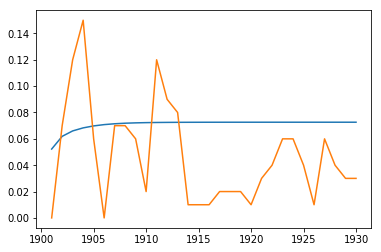

In [113]:
plt.plot(df_result[a+'_forecast'])
plt.plot(df_result[a])

Вывод: при обучении на агрегированных данных за весь период, модель не дает качественного прогнозного результата. Каждое последующее значение цены зависит от прогнозируемых значений ОИ и объемов, ошибка копится и в результате прогноз сходится к константе.

### Acuracy (агрегированная выборка)

In [114]:
results_var = df_result[a+'_forecast']
df_test_var = df_result[a]
df_result_var = pd.concat((df_test_var, results_var), axis=1)
sign_real = np.sign(df_test_var)
sign_pred = np.sign(results_var)
df_sign = pd.concat((sign_real, sign_pred), axis=1)
errors_sign = sign_real - sign_pred
errors_sign

1901   -1.0
1902    0.0
1903    0.0
1904    0.0
1905    0.0
1906   -1.0
1907    0.0
1908    0.0
1909    0.0
1910    0.0
1911    0.0
1912    0.0
1913    0.0
1914    0.0
1915    0.0
1916    0.0
1917    0.0
1918    0.0
1919    0.0
1920    0.0
1921    0.0
1922    0.0
1923    0.0
1924    0.0
1925    0.0
1926    0.0
1927    0.0
1928    0.0
1929    0.0
1930    0.0
dtype: float64

### Обучение внутри одного дня

Попробуем обучить модель внутри дня (всего 160 наблюдений), сохранив лаг модели.

In [133]:
# Первые 130 наблюдений - обучающая часть выборки, 30 - тестовая
nobs = 130

In [134]:
df_main_train, df_main_test = df_main[0:nobs], df_main[nobs:160]

# Check size
print(df_main_train.shape) 

print(df_main_test.shape)  



(130, 36)
(30, 36)


In [135]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, May, 2020
Time:                     22:46:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.0609
Nobs:                     1898.00    HQIC:                   10.0221
Log likelihood:          -17547.9    FPE:                    22015.1
AIC:                      9.99948    Det(Omega_mle):         21773.3
--------------------------------------------------------------------
Results for equation r_2
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000001         0.000000            4.903           0.000
L1.r_2                       0.080008         0.029180            2.742           0.006
L1.oi_diff                  -0.000

In [118]:
lag_order = model_fitted.k_ar

In [119]:
# Технические операции
forecast_input = df_main_train[[a, b, c]]
forecast_input2 = forecast_input.values[-lag_order:]
df_main_2 = df_main[[a, b, c]]

In [120]:
# Forecast
fc = model_fitted.forecast(y=forecast_input2, steps=30)
df_forecast = pd.DataFrame(fc, index=df_main_2.index[131:161], columns=df_main_2.columns + '_forecast')
df_forecast

df_result = pd.concat((df_forecast, df_main[[a, b,c ]][131:161]), axis=1)

In [121]:
df_result

,price_diff_15_abs_forecast,oi_diff_forecast,Vol_diff_lots_abs_forecast,price_diff_15_abs,oi_diff,Vol_diff_lots_abs
131,0.032691,-445.226430,1258.515165,0.04,-658,3468
132,0.050486,-238.042707,1632.224504,0.01,404,1210
133,0.059263,-168.808067,3087.056577,0.02,-40,2146
134,0.064166,-115.956029,4351.825149,0.04,1044,1589
135,0.067182,-84.323233,5210.830943,0.05,-1954,5221
136,0.069110,-66.024795,5762.427290,0.03,600,988
137,0.070356,-54.895823,6113.937050,0.10,506,5432
138,0.071161,-47.865506,6338.816484,0.19,1210,3597
139,0.071681,-43.353114,6483.245584,0.11,-12,2829
140,0.072015,-40.444260,6576.196839,0.09,374,9684


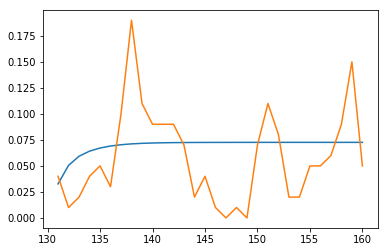

In [122]:
plt.plot(df_result[a+'_forecast'])
plt.plot(df_result[a])

In [123]:

sign_real = np.sign(df_result['price_diff_15'])
sign_pred = np.sign(df_result['price_diff_15_forecast'])
df_sign = pd.concat((sign_real, sign_pred), axis=1)
errors_sign = sign_real - sign_pred
signs_all = np.array(errors_sign)    
print(np.count_nonzero(signs_all))
signs_all.size

KeyError: 'price_diff_15'

# Accuracy_VAR

In [ ]:
# Диапазон для обучения внутри дня (нижняя и верхняя границы)
lst_fronts = [(0, 162), 
              (162, 323),
              (323, 484),
              (484, 645),
              (645, 807),
              (807, 967),
              (967, 1070),
              (1070, 1230),
              (1230, 1391),
              (1391, 1551),
              (1551, 1711),
              (1711, 1872),
              (1872, 2034),
              (2034, 2195),
              (2195, 2356)]

In [ ]:
# Первые 130 наблюдений - обучающая часть выборки, 30 - тестовая

l = 2195
h = 2354
nobs = h - 30

In [ ]:
df_main_train, df_main_test = df_main[l:nobs], df_main[nobs:h]
model_fitted = model.fit(6)
fc = model_fitted.forecast(y=forecast_input2, steps=30)
df_forecast = pd.DataFrame(fc, index=df_main_2.index[nobs+1:h+1], columns=df_main_2.columns + '_forecast')
df_forecast

df_result = pd.concat((df_forecast, df_main[[a, b,c ]][nobs+1:h+1]), axis=1)
sign_real = np.sign(df_result['price_diff_15'])
sign_pred = np.sign(df_result['price_diff_15_forecast'])
df_sign = pd.concat((sign_real, sign_pred), axis=1)
errors_sign = sign_real - sign_pred
signs_all = np.array(errors_sign)    
print(np.count_nonzero(signs_all))
signs_all.size